In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
sns.set_style('white')
sns.set_context('paper')
from scipy.special import gammaln

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #8
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 31st, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Application of Data Augmentation

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) \propto \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be understand the distribution of $\theta$ and make appropriate estimates.

### Part A: Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtain the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$


Derived the joint posterior $p(\theta, z  \vert  y)$ and sample from it using Gibbs sampling.

$$ p(\theta, z  \vert  y) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4} \theta^{a-1} \, (1-\theta)^{b-1}
$$

This can be simplified as follows:

$$ p(\theta, z  \vert  y) \propto \binom{y_{1}}{z} \left (\frac{1}{4} \right )^{\alpha+y_4} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z+\alpha + y_4}  (1-\theta)^{y_2+y_3+b-1}
$$

The conditional distributions for Gibbs sampling can now be derived:

$$ p(\theta \vert z, y) \propto \left(\frac{1}{4} \right )^{z+\alpha + y_4} \theta^{z+\alpha + y_4}  (1-\theta)^{y_2+y_3+b-1}
$$

Which is equivalent to a beta distribution with params $\alpha' = z+\alpha + y_4$ and $\beta' = y_2+y_3+b$

To obtain the conditional for z, keep only the terms from the joint which involve z:

$$ p(z  \vert  y,\theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z+\alpha + y_4} 
$$

To obtain a valid binomial distribution the probabilities $\left (\frac{1}{2} \right)$ and $\left(\frac{\theta}{4}\right)$ need to sum to 1. This involves dividing the probabilities by $\left (\frac{1}{2} \right) + \left(\frac{\theta}{4} \right)$ which results in the following form for the conditional disribution:


$$ p(z  \vert  y,\theta) \propto \binom{y_{1}}{z} \left (\frac{2}{2 +\theta} \right )^{y_1-z} \left(\frac{\theta}{2+ \theta} \right )^{z} 
$$

Which is a binomial distribution with $N=y_1$ and $p=\left (\frac{\theta}{2 +\theta} \right )$

Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

As we do not currently have any knowledge about $\theta$, a uniform prior can be used (a=1, b=1).

In [8]:
N=100000
thetas=np.zeros(N)
z=np.zeros(N)
thetas[0] = np.random.uniform()
z[0] = np.random.uniform()
a = 1
b = 1
y = [125,18,20,34]
for i in np.arange(1,N):
    alpha= a+z[i-1]+y[3]
    bta = b+y[1] + y[2]
    thetas[i] = stats.beta.rvs(alpha, bta)
    z[i] = stats.binom.rvs(n=y[0], p=(thetas[i]/(2+ thetas[i])))
    

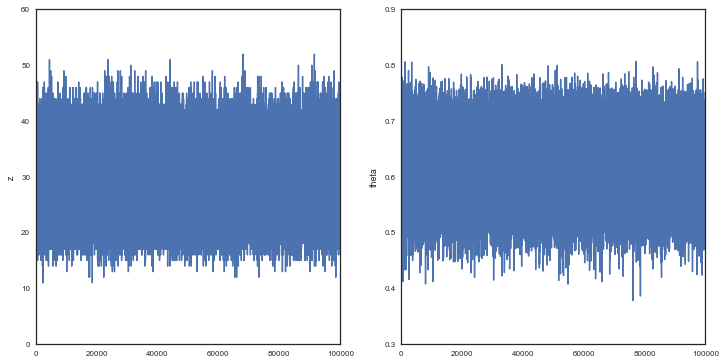

In [9]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(z)
plt.ylabel('z')
plt.subplot(1,2,2)
plt.plot(thetas)
plt.ylabel('theta')

# Remove burnin and thin the samples

In [10]:
thin=10
burnin=1000
ztrace=z[burnin+1:N:thin]
thetastrace=thetas[burnin+1:N:thin]
print(thetastrace.shape, ztrace.shape)

((9900,), (9900,))


# Check the samples are uncorrelated

In [11]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

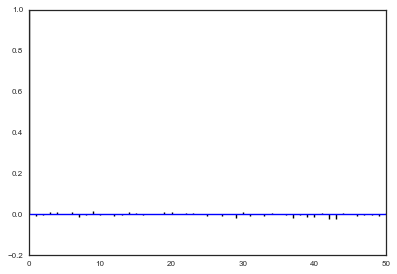

In [12]:
corrplot(ztrace)

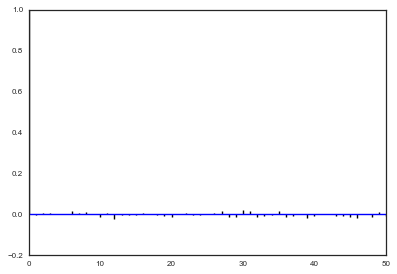

In [13]:
corrplot(thetastrace)

# Visualise the distribution of the theta

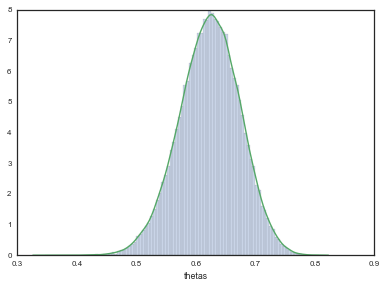

In [14]:
plt.hist(thetas, bins=100, alpha=0.3, normed=True);
sns.kdeplot(thetas)
plt.xlabel('thetas')

# Visualise the distribution of the trace

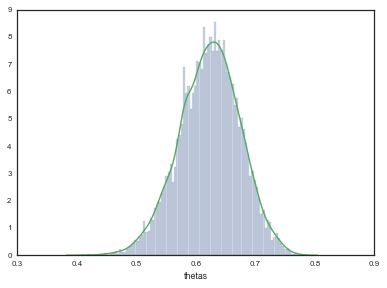

In [15]:
plt.hist(thetastrace, bins=100, alpha=0.3, normed=True);
sns.kdeplot(thetastrace)
plt.xlabel('thetas')

In [16]:
theta_final = np.mean(thetastrace)

In [17]:
print(theta_final)
print(theta_final/4)

0.622998036331
0.155749509083
0.0942504909172


The probability of obtaining a type 4 plant is 0.15. 